In [1]:
from nba_api.stats.endpoints import leagueleaders
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from nba_api.stats.endpoints import leaguedashplayerstats, synergyplaytypes
from nba_api.stats.endpoints import teamyearbyyearstats, playercareerstats
from nba_api.stats.static.players import find_players_by_full_name, find_player_by_id

from matplotlib.offsetbox import OffsetImage, AnnotationBbox, DrawingArea, TextArea
from matplotlib.patches import Circle, FancyArrowPatch, FancyArrow, ArrowStyle, Arrow
import matplotlib.ticker as mtick
import time
from tqdm import tqdm
from sklearn.cluster import KMeans
import numpy as np
import functools
import seaborn as sns
import glob
from sklearn import preprocessing
from scipy import stats
from fitter import Fitter, get_common_distributions, get_distributions
import sklearn
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import gamma, exponpow, lognorm, cauchy, genhyperbolic
from datetime import date


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

/var/folders/0l/bxmy5l011594gflgwzxxndhr0000gn/T/ipykernel_24257/4043954726.py:30: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
def convert_season_to_int(season):
    season = season.split('-')[0]
    return int(season) + 1

def convert_int_to_season(year):
    previos_year = year - 1
    year = str(year)
    previous_year = str(previos_year)
    year = year[-2:]
    return f'{previos_year}-{year}'

In [3]:
if_regular_season = True
first_year = 1990
last_year = 2024

all_players = pd.DataFrame()

for year in tqdm(range(first_year, last_year + 1)):
    season_year = convert_int_to_season(year)
    if if_regular_season:
        season_type = 'Regular Season'
    else:
        season_type = 'Playoffs'

    curr_players = leaguedashplayerstats.LeagueDashPlayerStats(per_mode_detailed='PerGame', 
                                                                      season=season_year, 
                                                                      season_type_all_star=season_type).get_data_frames()[0]
    
    curr_players['Season'] = season_year

    all_players = pd.concat([all_players, curr_players])
    
    time.sleep(0.5)

100%|██████████| 35/35 [01:20<00:00,  2.30s/it]


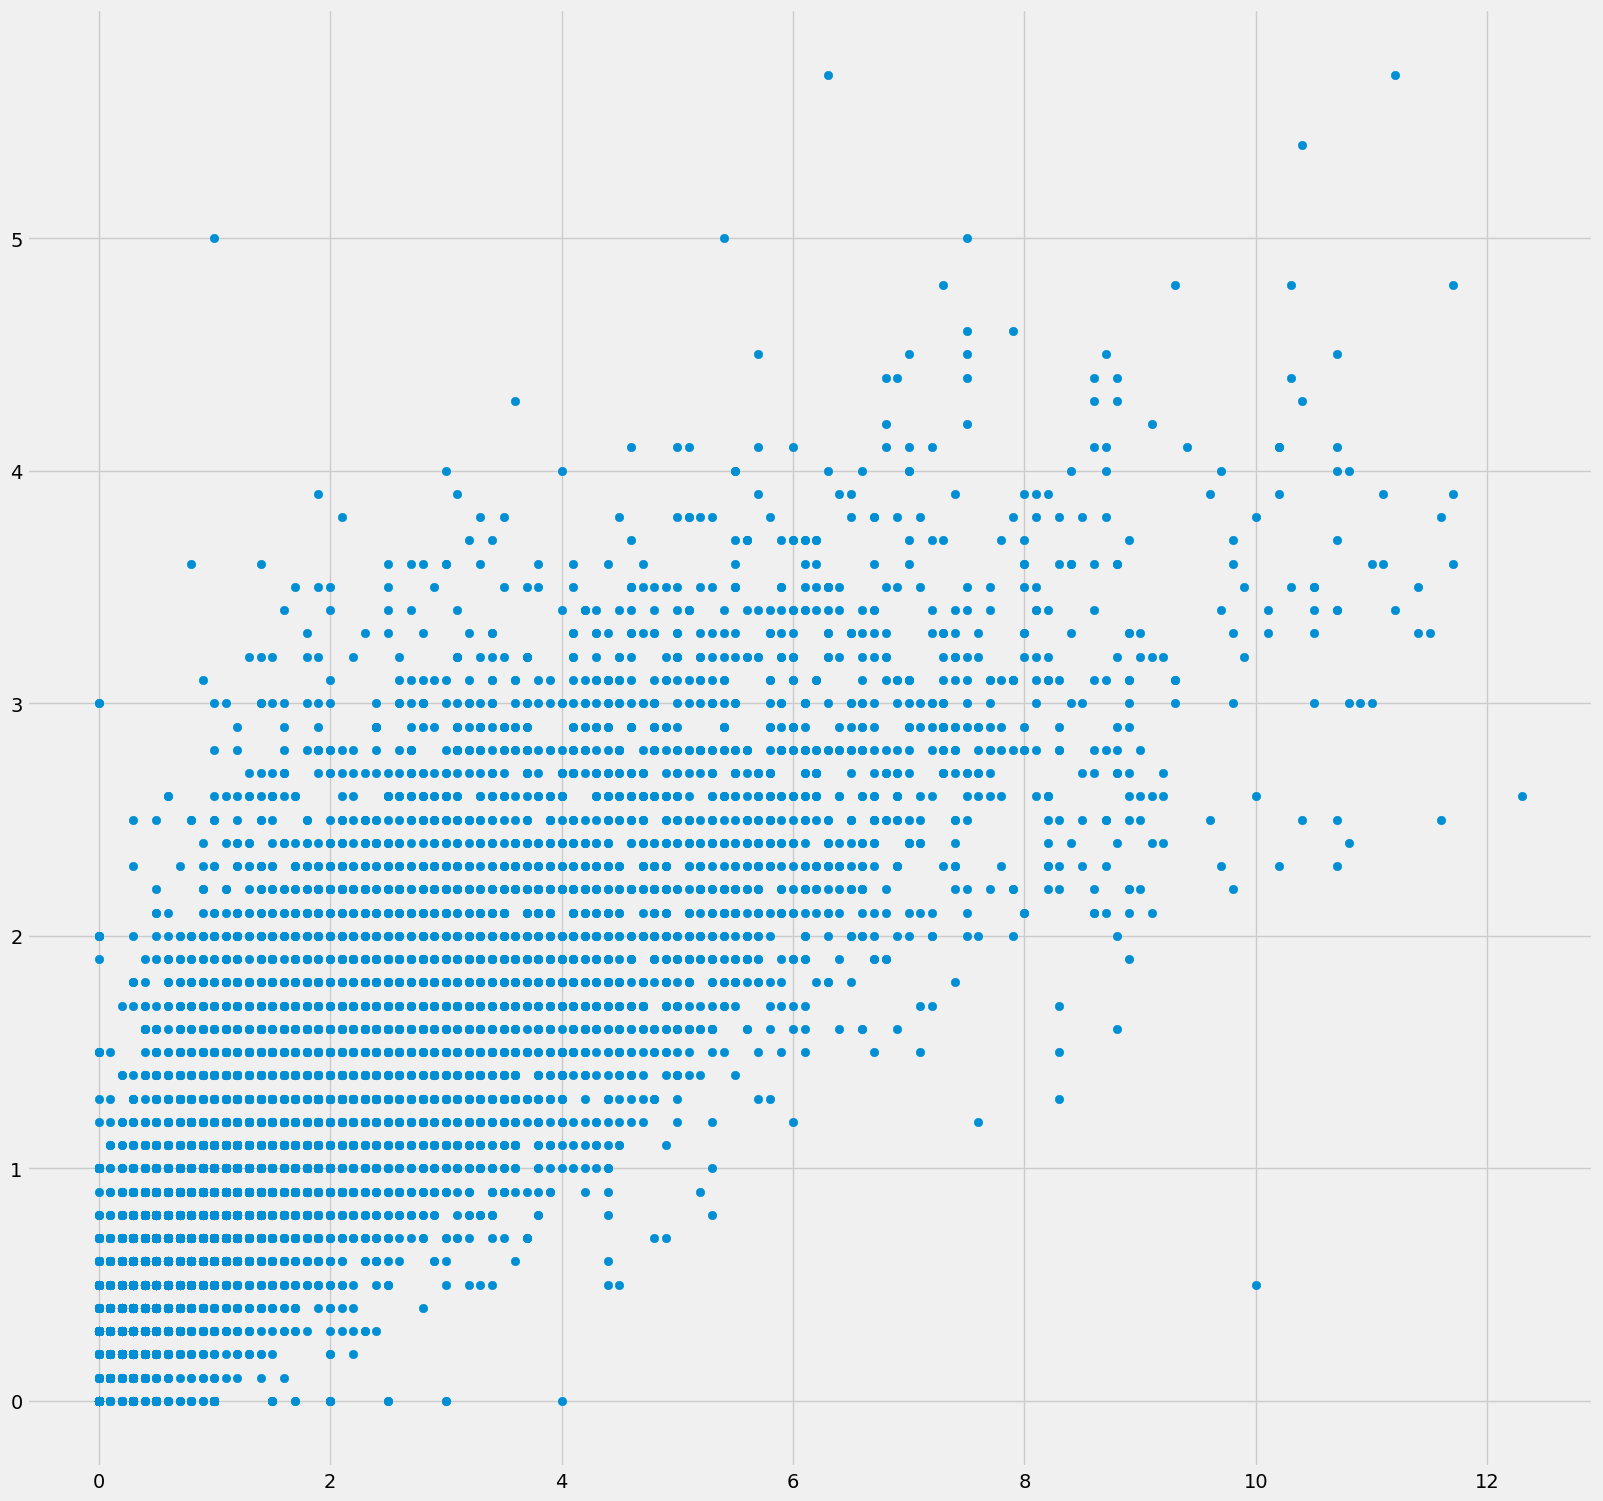

In [4]:
all_players['AST/TO Ratio'] = all_players['AST'] / all_players['TOV']

plt.figure(figsize=(18, 18))

plt.scatter(all_players['AST'], all_players['TOV'])

In [5]:
clean_ratio_players = all_players.replace([np.inf, -np.inf], np.nan).dropna(axis=0).sort_values(by=['AST/TO Ratio'], ascending=False)

In [6]:
clean_ratio_players.columns

columns_to_keep = [
'PLAYER_ID', 'PLAYER_NAME', 'GP', 'AST', 'TOV', 'PTS', 'Season','AST/TO Ratio'
]

In [7]:
more40_more7 = clean_ratio_players[(clean_ratio_players['GP'] > 50) & (clean_ratio_players['AST'] >= 7)][columns_to_keep].sort_values(by=['AST', 'AST/TO Ratio'], ascending=False)

460    12.3
Name: AST, dtype: float64 460    2.6
Name: TOV, dtype: float64
4.730769230769231


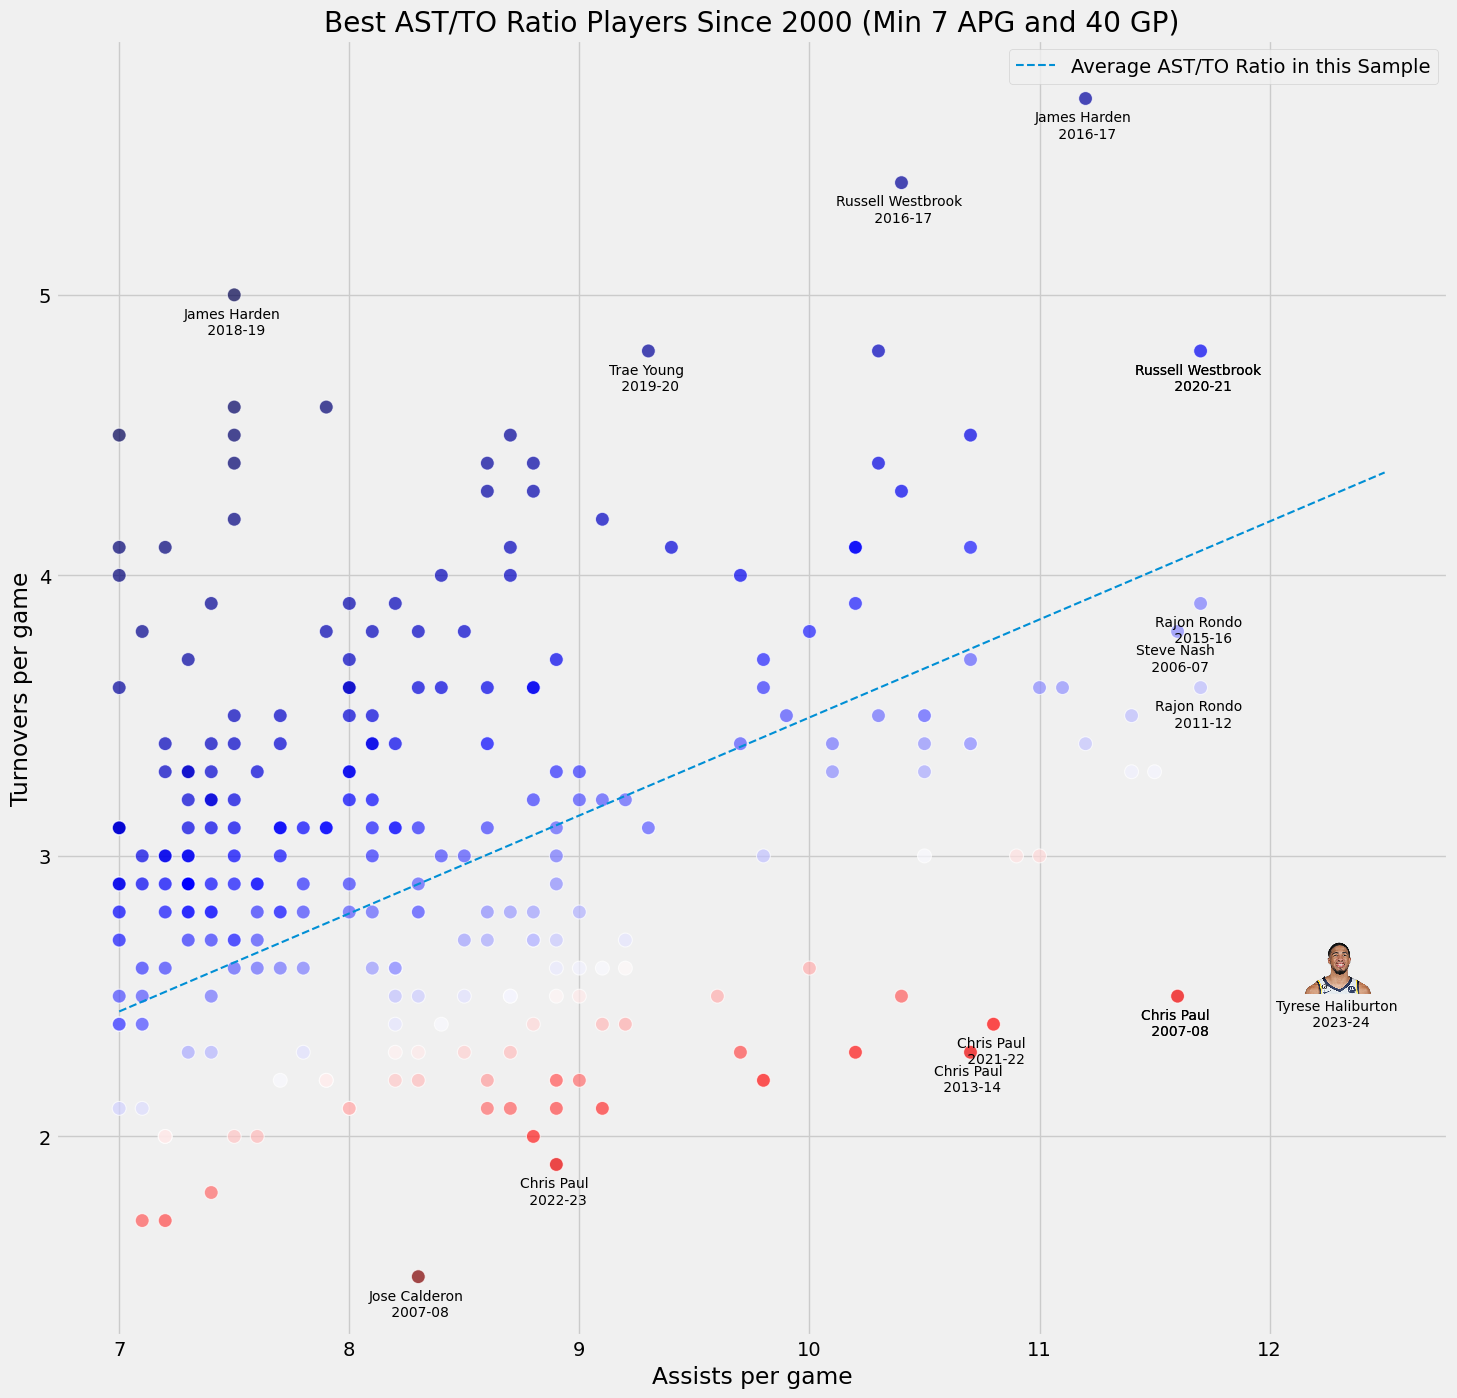

In [68]:
def get_player_img(player_id):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)

zoom = 0.2
player_root_dir = 'player_imgs/'

# fig, ax = plt.subplot(figsize=(12, 12))
fig, ax = plt.subplots(figsize=(16, 16))

average_ratio = np.average(more40_more7['AST/TO Ratio'])

ax.plot([7, 12.5], [7 / average_ratio, 12.5 / average_ratio], '--', lw=1.5, label='Average AST/TO Ratio in this Sample')

g = sns.scatterplot(data=more40_more7, x='AST', y='TOV', hue=more40_more7['AST/TO Ratio'], s=100, alpha=0.7, edgecolors='black', palette='seismic', ax=ax, legend=False)
# plt.scatter(more40_more7.AST, more40_more7.TOV)

outliers = pd.DataFrame()
most_to_players = more40_more7.sort_values(by=['TOV']).tail(5)
least_to_players = more40_more7.sort_values(by=['TOV']).head(5)
most_ast_players = more40_more7.sort_values(by=['AST']).tail(5)

best_ratio_players = more40_more7.sort_values(by=['AST/TO Ratio'], ascending=False).head(5)

tyrese = all_players[all_players.PLAYER_NAME == 'Tyrese Haliburton'].tail(1)

outliers = pd.concat([outliers, best_ratio_players, most_ast_players, most_to_players])
# outliers = pd.concat([outliers, least_to_players])

print(tyrese.AST, tyrese.TOV)

outliers.drop_duplicates()
for i in range(len(outliers)):
    player = outliers.iloc[i]
    player_id, player_name, season = player.PLAYER_ID, player.PLAYER_NAME, player.Season
    ab = AnnotationBbox(TextArea(f'{player_name} \n {season}', textprops={'size': 10, 'va': 'top', 'ha': 'center'}), (player.AST, player.TOV), frameon=False)
    ax.add_artist(ab)
    
for i in range(len(tyrese)):
    player = tyrese.iloc[i]
    player_id, player_name, season = player.PLAYER_ID, player.PLAYER_NAME, player.Season
    print(player.AST / player.TOV)
    # ab = AnnotationBbox(TextArea(f'{player_name} \n {season}', textprops={'size': 10, 'va': 'top'}), (player.AST, player.TOV), frameon=False)
    ab = AnnotationBbox(get_player_img(player_id), (player.AST, player.TOV), frameon=False)
    ax.add_artist(ab)
    ab = AnnotationBbox(TextArea(f'{player_name} \n {season}', textprops={'size': 10, 'va': 'bottom', 'ha': 'center'}), (player.AST, player.TOV - 0.175), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel('Assists per game')
ax.set_ylabel('Turnovers per game')
ax.set_title('Best AST/TO Ratio Players Since 2000 (Min 7 APG and 40 GP)')
plt.legend()

plt.savefig('Graphs/hali_pointgod.png', bbox_inches='tight')